# MAIN

In [1]:
# ========== 0. MAIN ==========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import datetime
import random

# Data Loading & Preprocessing

In [ ]:
# ========== 1. Data Loading & Preprocessing ==========

# Update the file paths if the CSV files are in a different directory.
features = pd.read_csv("features-daily_2024-11_dairy.csv", 
                       parse_dates=['daydate', 'currentlastsalesdate', 'currentlastreceiptdate', 'lastsalesdate', 'storeDate'])
labels = pd.read_csv("labels_2024-11_dairy.csv", 
                     parse_dates=['storeDate', 'historyTime', 'outOfShelfTime', 'PlannedAbandonmentDate'])
trxn = pd.read_csv("trxn_2024-11_dairy.csv", 
                   parse_dates=['TransactionDate', 'TransactionTime', 'TransactionInitiatedTimestamp', 
                                'TransactionLineItemScanTimestamp', 'TransactionLineItemScanUTCTimestamp'])

# Remove holiday data (Thanksgiving) based on the assumption that Thanksgiving is on 2024-11-28.
# If you have more holiday dates or a different approach, update this section accordingly.
holiday_date = pd.Timestamp('2024-11-28')
features = features[features['daydate'] != holiday_date]
labels = labels[labels['storeDate'] != holiday_date]
trxn = trxn[trxn['TransactionDate'] != holiday_date]

# Drop duplicates if any
features.drop_duplicates(inplace=True)
labels.drop_duplicates(inplace=True)
trxn.drop_duplicates(inplace=True)

# Phantom Inventory Flagging

In [3]:
# ========== 2. Phantom Inventory Flagging ==========

# Aggregate the transaction data to the daily level per SKU.
# For example, summing total quantity and counting the number of transactions.
trxn_agg = trxn.groupby(['ItemSku', 'TransactionDate']).agg({
    'TotalItemQuantity': 'sum',    # Total quantity sold in transactions
    'TransactionId': 'nunique',    # Number of unique transactions
    'Quantity': 'sum',             # Alternatively, use Quantity if it captures sold units
    'VoidIndicator': 'sum'         # Sum here gives number of voided transactions per day
}).reset_index()

# Rename columns to align with the features dataset
trxn_agg.rename(columns={
    'ItemSku': 'itemsku', 
    'TransactionDate': 'daydate',
    'TotalItemQuantity': 'trxn_total_qty',
    'TransactionId': 'trxn_count',
    'Quantity': 'trxn_quantity',
    'VoidIndicator': 'void_count'
}, inplace=True)

# Merge aggregated transaction data with features based on itemsku and daydate.
features = features.merge(trxn_agg, on=['itemsku', 'daydate'], how='left')
# Fill missing transaction data with 0. # Fill missing values (i.e., days with no transactions) with 0
features['trxn_total_qty'] = features['trxn_total_qty'].fillna(0)
features['trxn_count'] = features['trxn_count'].fillna(0)
features['trxn_quantity'] = features['trxn_quantity'].fillna(0)
features['void_count'] = features['void_count'].fillna(0)

# Merge the features and labels data on product identifier and date.
# Here, we assume the join keys are: 'itemsku' in features and 'ItemSku' in labels,
# and that 'daydate' in features corresponds to 'storeDate' in labels.
merged = pd.merge(
    features, 
    labels, 
    left_on=['itemsku', 'daydate'], 
    right_on=['ItemSku', 'storeDate'], 
    how='left')

# Merge aggregated transaction data with the merged features/labels dataset.
merged = pd.merge(merged, trxn_agg, on=['itemsku', 'daydate'], how='left')

# Rule 1: If the product is flagged as out-of-shelf in labels (i.e. outOfShelf is True) 
# and the reported current balance on hand (DailyBOH) is greater than 0,
# then it may be a phantom inventory.
merged['phantom_flag'] = np.where((merged['outOfShelf'] == True) & (merged['DailyBOH'] > 0), 1, 0)

# Rule 2 (alternative/additional): If, for example, the product is reported as in-stock (PositiveBOHFlag==1),
# but there are no sales (salesQuantity == 0) and there is an out-of-stock count (OOSCount > 0),
# then flag it as phantom.
merged['phantom_flag'] = np.where( (merged['phantom_flag'] == 1) | 
                                   ((merged['PositiveBOHFlag'] == 1) & 
                                    (merged['salesQuantity'] == 0) & 
                                    (merged['OOSCount'] > 0)), 1, 0)

# Features Engineering

In [4]:
# ========== 3. Features Engineering ==========

# 1. Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# 2. Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 3. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 4. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 5.  Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# 6. Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# 7. Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# 8. Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

# 9. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 10. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 11. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 12. Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 13. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cat. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio',
                   'is_weekend', 'out_of_stock_duration']
target_column = 'phantom_flag'

# [Random Forest] Model Building: Phantom Inventory Classifier

CV ROC‑AUC mean ± std: 0.829 ± 0.026
Best CV ROC‑AUC: 0.8287887075393945
Precision≥0.90 threshold = 0.33, Precision = 0.901, Recall = 0.537
Test F1: 0.6720509055310817
Test recall: 0.5340334500194477
Test precision: 0.9062706270627062
Test ROC‑AUC: 0.876313920154368


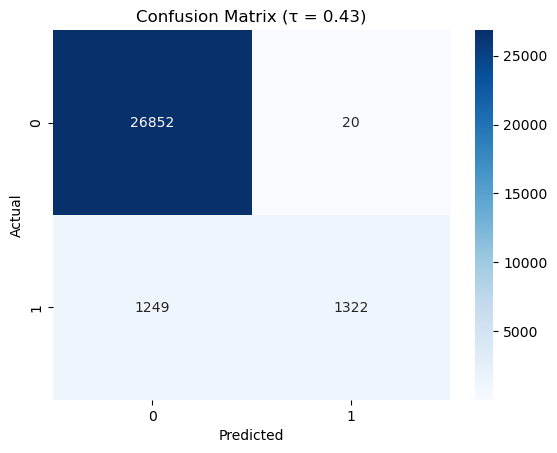

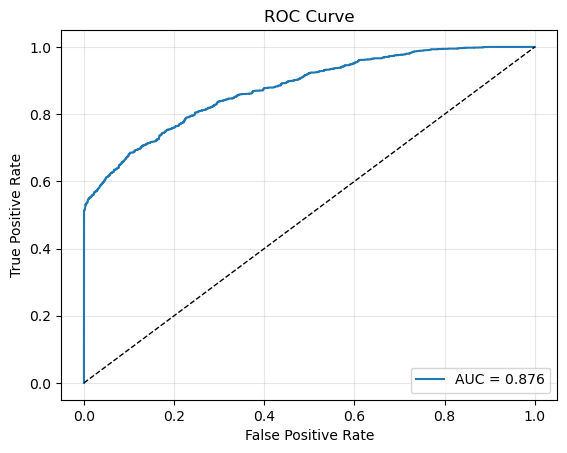

In [ ]:
# ========== 4. [Random Forest] Model Building | Phantom Inventory Classifier ==========

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_recall_curve, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
import numpy as np

# ------------------------------
# 1.  Train–test split *by SKU* or *by date* (pick one)
# ------------------------------
X = model_data[feature_columns]
y = model_data[target_column]
groups = model_data['itemsku']          #  or daydate.dt.date if doing time splits
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=0.2, random_state=42, stratify=y)

# ------------------------------
# 2.  Pre‑processing & model
# ------------------------------
cat_cols = ['DayofWeek']
num_cols = [c for c in feature_columns if c not in cat_cols]

pre = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

rf = RandomForestClassifier(
        n_estimators=800,
        max_depth=10,
        min_samples_leaf=20,
        max_features=0.3,
        bootstrap=True,
        oob_score=True,
        class_weight={0:1, 1:4},
        random_state=42
)

pipe = Pipeline([('prep', pre),
                 ('rf',   rf)])

# ------------------------------
# 3.  Cross‑validation without leakage
# ------------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe, X_train, y_train, groups=g_train,
                      cv=cv, scoring='roc_auc')
print(f'CV ROC‑AUC mean ± std: {auc.mean():.3f} ± {auc.std():.3f}')

# ------------------------------
# 4.  Hyper‑parameter search (optional)
# ------------------------------
param_dist = {
    'rf__n_estimators':  randint(400, 1200),
    'rf__max_depth':     randint(5, 15),
    'rf__min_samples_leaf': randint(5, 50),
    'rf__max_features':  uniform(0.2, 0.4)  #  0.2–0.6
}
search = RandomizedSearchCV(pipe, param_dist,
                            n_iter=20, cv=cv, n_jobs=-1,
                            scoring='roc_auc', random_state=42)
search.fit(X_train, y_train, groups=g_train)
best_model = search.best_estimator_
print('Best CV ROC‑AUC:', search.best_score_)

# ------------------------------
# 5.  Fit best model on full train, then tune threshold
# ------------------------------
best_model.fit(X_train, y_train)
proba = best_model.predict_proba(X_train)[:,1]

# prec, rec, thr = precision_recall_curve(y_train, proba)
# f1 = 2*prec*rec/(prec+rec)
# best_thr = thr[np.argmax(f1)]
# print(f'Best threshold for F1 = {best_thr:.2f}, F1 = {f1.max():.3f}')

from sklearn.metrics import precision_recall_curve

proba_val = best_model.predict_proba(X_train)[:, 1]   # or use a CV‑held fold
prec, rec, thr = precision_recall_curve(y_train, proba_val)

# Find the *smallest* threshold that gets you precision ≥ 0.90
target_p  = 0.90
idx       = np.where(prec[:-1] >= target_p)[0]
if len(idx):
    best_thr_p90 = thr[idx[0]]
    print(f'Precision≥0.90 threshold = {best_thr_p90:.2f}, '
          f'Precision = {prec[idx[0]]:.3f}, Recall = {rec[idx[0]]:.3f}')
else:
    print('Model never reaches 0.90 precision')

# ------------------------------
# 6.  Evaluate on the untouched test set
# ------------------------------
proba_test = best_model.predict_proba(X_test)[:,1]
y_pred = (proba_test >= best_thr_p90).astype(int)
print('Test F1:', f1_score(y_test, y_pred))
print('Test recall:', recall_score(y_test, y_pred))
print('Test precision:', precision_score(y_test, y_pred))
print('Test ROC‑AUC:', roc_auc_score(y_test, proba_test))

# ----------------------------------------
# 7.  Plotting
# ----------------------------------------
threshold = 0.43       # Precision ≥ 0.90 the cut‑off
y_proba   = best_model.predict_proba(X_test)[:, 1]
y_pred    = (y_proba >= threshold).astype(int)

# 1) Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (τ = {:.2f})'.format(threshold))
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Model Evaluation
# SHAP Explanation


==================== Evaluating Feature Importance & SHAP ====================

Calculating Random Forest Built-in Feature Importance...


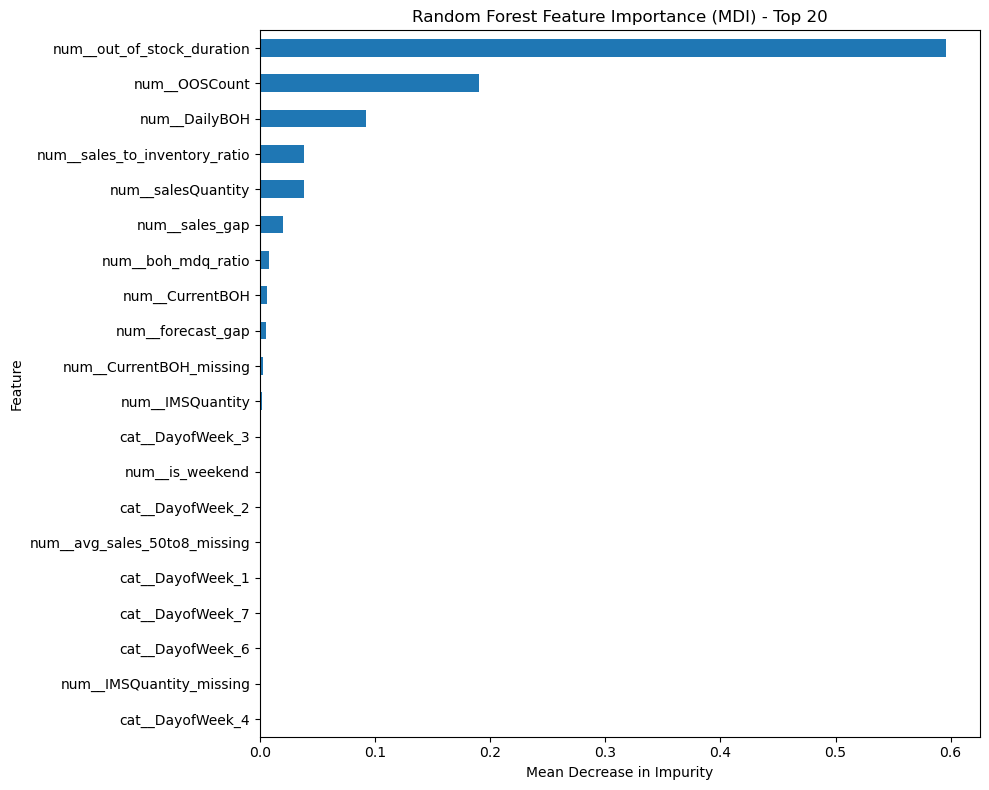


Calculating SHAP values...
DEBUG: Type of rf_model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
DEBUG: rf_model object: RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=6,
                       max_features=0.4158768529556319, min_samples_leaf=28,
                       n_estimators=616, oob_score=True, random_state=42)
DEBUG: rf_model.n_features_in_: 22
DEBUG: rf_model.classes_: [0 1]
DEBUG: rf_model.n_outputs_: 1
DEBUG: explainer object: <shap.explainers._tree.TreeExplainer object at 0x36d207f10>
DEBUG: explainer.expected_value (initial): [0.72328211 0.27671789]
DEBUG: Shape of X_test_transformed_df (input to shap_values): (29443, 22)
DEBUG: Number of features names: 22

DEBUG: Testing SHAP with a small DataFrame sample (first 5 rows)...
DEBUG: Shape of X_sample_df: (5, 22)
DEBUG: Shape of shap_values_sample_df (not a list): (5, 22, 2)

DEBUG: Testing SHAP with a small NumPy array sample (first 5 rows of dense data)...
DEBUG: Shape of X_sample_np: (5, 22)
D

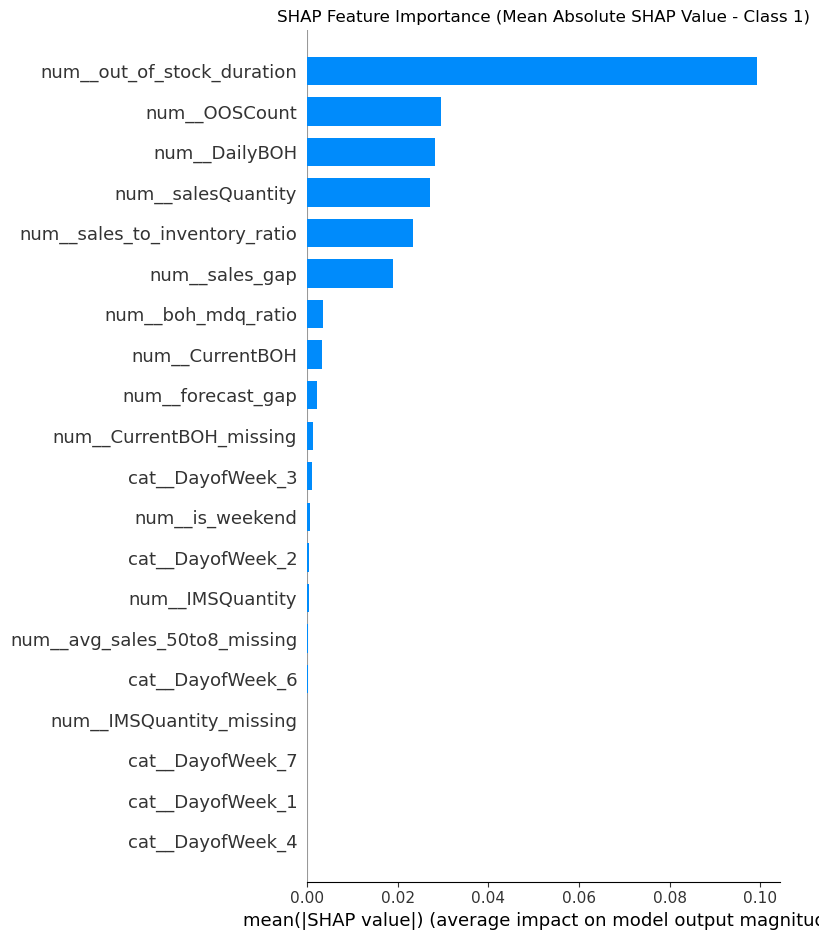


Generating SHAP Summary Plot (Beeswarm)...


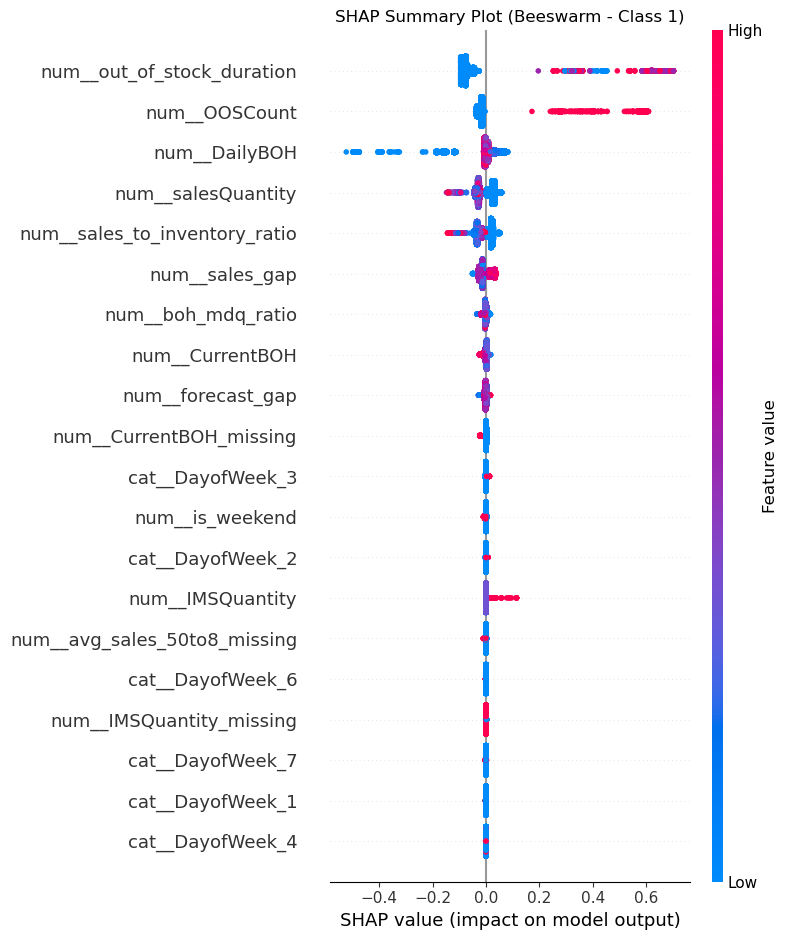


Generating SHAP Dependence Plot for feature: num__out_of_stock_duration (Class 1)...


<Figure size 640x480 with 0 Axes>

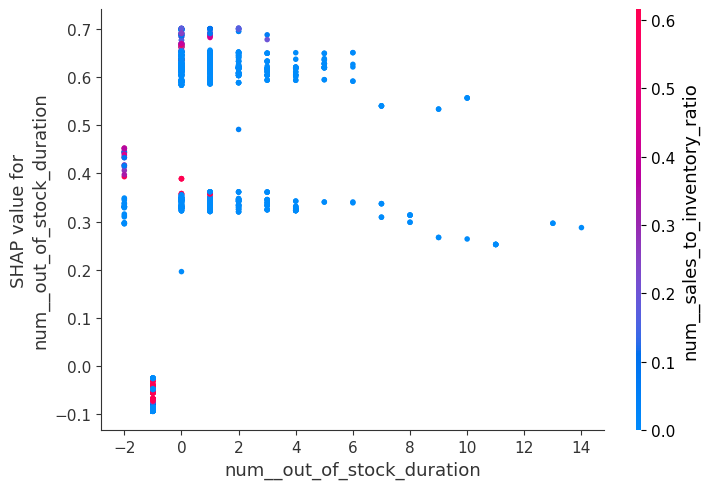


==================== Evaluation Complete ====================


In [ ]:
# ========== 5. Model Evaluation - Feature Importance & SHAP ==========
import matplotlib.pyplot as plt
import pandas as pd
import shap

# Ensure plots are displayed correctly in notebooks if needed
# %matplotlib inline

print("\n" + "="*20 + " Evaluating Feature Importance & SHAP " + "="*20)

# ------------------------------
# 5.1. Get the fitted model and preprocessor
# ------------------------------
# Access the preprocessing step ('prep') and the RandomForest model ('rf') from the pipeline
preprocessor = best_model.named_steps['prep']
rf_model = best_model.named_steps['rf']

# Get the feature names after transformation (e.g., after one-hot encoding)
# These are the names the RandomForest model actually sees
try:
    feature_names_transformed = preprocessor.get_feature_names_out()
except AttributeError:
    # Handle older scikit-learn versions if necessary, though get_feature_names_out is preferred
    # This might require more complex handling depending on the transformers used
    print("Warning: Could not automatically get transformed feature names. Using generic names.")
    # Generate generic names as a fallback
    n_features_out = preprocessor.transform(X_test).shape[1]
    feature_names_transformed = [f'feature_{i}' for i in range(n_features_out)]

# ------------------------------
# 5.2. Random Forest Built-in Feature Importance (Mean Decrease in Impurity)
# ------------------------------
print("\nCalculating Random Forest Built-in Feature Importance...")

# Get feature importances from the fitted RandomForest model
importances_mdi = rf_model.feature_importances_

# Create a pandas Series for easier handling and plotting
importance_series_mdi = pd.Series(importances_mdi, index=feature_names_transformed)

# Sort features by importance
importance_series_mdi = importance_series_mdi.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
# Plot top N features for clarity, e.g., top 20
top_n = min(len(importance_series_mdi), 20)
importance_series_mdi.head(top_n).sort_values(ascending=True).plot(kind='barh')
plt.title(f'Random Forest Feature Importance (MDI) - Top {top_n}')
plt.xlabel('Mean Decrease in Impurity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ------------------------------
# 5.3. SHAP Value Calculation and Visualization
# ------------------------------
print("\nCalculating SHAP values...")

# --- Get the model and preprocessor ---
preprocessor = best_model.named_steps['prep']
rf_model = best_model.named_steps['rf']

# --- DEBUG: Model and Preprocessor Info ---
print(f"DEBUG: Type of rf_model: {type(rf_model)}")
print(f"DEBUG: rf_model object: {rf_model}")
if hasattr(rf_model, 'n_features_in_'):
    print(f"DEBUG: rf_model.n_features_in_: {rf_model.n_features_in_}")
if hasattr(rf_model, 'classes_'):
    print(f"DEBUG: rf_model.classes_: {rf_model.classes_}")
if hasattr(rf_model, 'n_outputs_'): # For some models
    print(f"DEBUG: rf_model.n_outputs_: {rf_model.n_outputs_}")

# --- Initialize the SHAP explainer ---
explainer = shap.TreeExplainer(rf_model)
print(f"DEBUG: explainer object: {explainer}")
if hasattr(explainer, 'expected_value'):
    # Note: expected_value might be computed lazily upon first shap_values call for some explainers
    # This print might show an initial state if called too early.
    print(f"DEBUG: explainer.expected_value (initial): {explainer.expected_value}")

# --- Prepare transformed data (as DataFrame) ---
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed_dense = X_test_transformed.toarray()
else:
    X_test_transformed_dense = X_test_transformed

try:
    feature_names_transformed = preprocessor.get_feature_names_out()
except AttributeError:
    n_features_out = X_test_transformed_dense.shape[1]
    feature_names_transformed = [f'feature_{i}' for i in range(n_features_out)]

X_test_transformed_df = pd.DataFrame(X_test_transformed_dense, columns=feature_names_transformed)
print(f"DEBUG: Shape of X_test_transformed_df (input to shap_values): {X_test_transformed_df.shape}")
print(f"DEBUG: Number of features names: {len(feature_names_transformed)}")

# --- DEBUG: Test SHAP with a small sample of the DataFrame ---
print("\nDEBUG: Testing SHAP with a small DataFrame sample (first 5 rows)...")
X_sample_df = X_test_transformed_df.head(5)
print(f"DEBUG: Shape of X_sample_df: {X_sample_df.shape}")
try:
    shap_values_sample_df = explainer.shap_values(X_sample_df)
    if isinstance(shap_values_sample_df, list):
        print(f"DEBUG: shap_values_sample_df is a list of length {len(shap_values_sample_df)}")
        if len(shap_values_sample_df) > 0: print(f"DEBUG: Shape of shap_values_sample_df[0]: {shap_values_sample_df[0].shape}")
        if len(shap_values_sample_df) > 1: print(f"DEBUG: Shape of shap_values_sample_df[1]: {shap_values_sample_df[1].shape}")
    else:
        print(f"DEBUG: Shape of shap_values_sample_df (not a list): {shap_values_sample_df.shape}")
except Exception as e:
    print(f"DEBUG: Error during SHAP calculation for DataFrame sample: {str(e)[:500]}") # Print limited error length

# --- DEBUG: Test SHAP with a small sample of the NumPy array ---
print("\nDEBUG: Testing SHAP with a small NumPy array sample (first 5 rows of dense data)...")
X_sample_np = X_test_transformed_dense[:5, :]
print(f"DEBUG: Shape of X_sample_np: {X_sample_np.shape}")
try:
    shap_values_sample_np = explainer.shap_values(X_sample_np)
    if isinstance(shap_values_sample_np, list):
        print(f"DEBUG: shap_values_sample_np is a list of length {len(shap_values_sample_np)}")
        if len(shap_values_sample_np) > 0: print(f"DEBUG: Shape of shap_values_sample_np[0]: {shap_values_sample_np[0].shape}")
        if len(shap_values_sample_np) > 1: print(f"DEBUG: Shape of shap_values_sample_np[1]: {shap_values_sample_np[1].shape}")
    else:
        print(f"DEBUG: Shape of shap_values_sample_np (not a list): {shap_values_sample_np.shape}")
except Exception as e:
    print(f"DEBUG: Error during SHAP calculation for NumPy sample: {str(e)[:500]}")

# --- Calculate SHAP values for the full test set (using DataFrame) ---
print("\nDEBUG: Calculating SHAP values for the full X_test_transformed_df...")
try:
    # shap_values_raw is expected to be a NumPy array (N, M, C) based on debug output
    shap_values_raw = explainer.shap_values(X_test_transformed_df)
except Exception as e:
    print(f"CRITICAL ERROR during full shap_values calculation: {e}")
    # Create a dummy array matching expected output structure if possible
    n_samples_dummy = X_test_transformed_df.shape[0] if X_test_transformed_df.shape[0] > 0 else 1
    n_features_dummy = X_test_transformed_df.shape[1] if X_test_transformed_df.shape[1] > 0 else 1
    n_classes_dummy = len(rf_model.classes_) if hasattr(rf_model, 'classes_') else 2
    shap_values_raw = np.zeros((n_samples_dummy, n_features_dummy, n_classes_dummy))

# --- Post-calculation debug prints ---
if hasattr(explainer, 'expected_value'):
     print(f"DEBUG: explainer.expected_value (after full calculation): {explainer.expected_value}")

print(f"\nDEBUG: Type of shap_values_raw (full calculation): {type(shap_values_raw)}")
print(f"DEBUG: Shape of shap_values_raw (full calculation): {shap_values_raw.shape if isinstance(shap_values_raw, np.ndarray) else 'Not an array'}")

# --- Extract SHAP values and expected value for the Positive Class (index 1) ---
shap_values_positive_class = None # Will hold the (N, M) array for class 1
expected_value_positive_class = None # Will hold the expected value for class 1
can_plot_shap = False # Default to False unless extraction succeeds

# Check if shap_values_raw is a 3D NumPy array with the last dimension matching number of classes
if isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3 and \
   hasattr(rf_model, 'classes_') and shap_values_raw.shape[-1] == len(rf_model.classes_):

    n_samples, n_features, n_classes = shap_values_raw.shape
    print(f"DEBUG: Raw SHAP values have 3 dimensions: (samples={n_samples}, features={n_features}, classes={n_classes})")

    # Find the index corresponding to the positive class (class 1)
    try:
        # Assuming rf_model.classes_ is something like [0, 1]
        positive_class_index = list(rf_model.classes_).index(1)
        print(f"DEBUG: Positive class (1) found at index {positive_class_index} in model classes {rf_model.classes_}.")
    except ValueError:
        print("ERROR: Class '1' not found in model.classes_. Cannot determine positive class index.")
        positive_class_index = -1 # Indicate error

    if positive_class_index != -1:
        print(f"DEBUG: Extracting SHAP values for class index {positive_class_index} (Class 1).")
        # Extract the (N, M) slice for the positive class
        shap_values_positive_class = shap_values_raw[:, :, positive_class_index]

        # Extract corresponding expected value if possible
        if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) == n_classes:
            expected_value_positive_class = explainer.expected_value[positive_class_index]
            print(f"DEBUG: Extracted expected_value for class index {positive_class_index}: {expected_value_positive_class}")
        else:
            print("DEBUG: Could not reliably extract expected_value for the specific class.")

        # Final check on the extracted shape (should be N, M)
        if shap_values_positive_class.shape == (X_test_transformed_df.shape[0], X_test_transformed_df.shape[1]):
            print(f"DEBUG: Extracted shap_values_positive_class shape {shap_values_positive_class.shape} matches expected (N, M). Setting can_plot_shap=True.")
            can_plot_shap = True
        else:
            print(f"ERROR: Extracted shap_values_positive_class shape {shap_values_positive_class.shape} STILL does not match expected (N, M) shape {(X_test_transformed_df.shape[0], X_test_transformed_df.shape[1])}.")
            # Keep can_plot_shap as False
else:
    # Handle cases where shap_values_raw wasn't the expected 3D array
    print(f"ERROR: Raw SHAP values shape ({shap_values_raw.shape if isinstance(shap_values_raw, np.ndarray) else type(shap_values_raw)}) is not the expected 3D array (N, M, C) or class dimension mismatch.")
    # Keep can_plot_shap as False

# Assign shap_values_plot ONLY if plotting is possible
if can_plot_shap:
    shap_values_plot = shap_values_positive_class # This should now be (N, M)
    print(f"DEBUG: Proceeding with plots using shap_values_plot of shape {shap_values_plot.shape}")
else:
    # Provide a dummy variable if plotting is not possible
    n_samples_dummy = X_test_transformed_df.shape[0] if X_test_transformed_df.shape[0] > 0 else 1
    n_features_dummy = X_test_transformed_df.shape[1] if X_test_transformed_df.shape[1] > 0 else 1
    shap_values_plot = np.zeros((n_samples_dummy, n_features_dummy))
    print("DEBUG: Setting shap_values_plot to dummy array as can_plot_shap is False.")

# --- SHAP Plots (guarded by can_plot_shap) ---
if 'can_plot_shap' in locals() and can_plot_shap:
    print("\nAttempting to generate SHAP plots using extracted class 1 values...")

    # SHAP Summary Plot (Bar)
    print("Generating SHAP Summary Plot (Bar)...")
    plt.figure()
    try:
        # shap_values_plot should now be (N, M)
        shap.summary_plot(shap_values_plot, X_test_transformed_df, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Mean Absolute SHAP Value - Class 1)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"ERROR generating SHAP bar plot: {e}")
        plt.close() # Close potentially broken plot

    # SHAP Summary Plot (Beeswarm)
    print("\nGenerating SHAP Summary Plot (Beeswarm)...")
    plt.figure()
    try:
        # shap_values_plot should now be (N, M)
        shap.summary_plot(shap_values_plot, X_test_transformed_df, show=False)
        # Add title manually if needed
        plt.title('SHAP Summary Plot (Beeswarm - Class 1)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"ERROR generating SHAP beeswarm plot: {e}")
        plt.close() # Close potentially broken plot

    # SHAP Dependence Plot
    # Check dimensions again just to be safe before plotting
    if shap_values_plot.shape[0] == X_test_transformed_df.shape[0] and shap_values_plot.shape[1] == X_test_transformed_df.shape[1]:
        if len(feature_names_transformed) > 0 and X_test_transformed_df.shape[0] > 0:
            try:
                mean_abs_shap = np.abs(shap_values_plot).mean(0)
                if len(mean_abs_shap) > 0:
                    most_important_shap_feature_index = np.argsort(mean_abs_shap)[-1]
                    most_important_shap_feature = X_test_transformed_df.columns[most_important_shap_feature_index]
                    print(f"\nGenerating SHAP Dependence Plot for feature: {most_important_shap_feature} (Class 1)...")
                    plt.figure()
                    # shap_values_plot should now be (N, M)
                    shap.dependence_plot(most_important_shap_feature, shap_values_plot, X_test_transformed_df, interaction_index="auto", show=False)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("DEBUG: No features to plot for dependence plot (mean_abs_shap is empty).")
            except Exception as e:
                print(f"ERROR generating SHAP dependence plot: {e}")
                plt.close() # Close potentially broken plot
        else:
            print("Skipping SHAP dependence plot due to inconsistent data or empty features.")
    else:
        print(f"Skipping SHAP dependence plot due to shape mismatch just before plotting: SHAP={shap_values_plot.shape}, Data={X_test_transformed_df.shape}")

else:
    # This 'else' corresponds to the 'if' checking can_plot_shap
    print("\nSKIPPING SHAP PLOTS due to issues extracting or validating SHAP values.")

print("\n" + "="*20 + " Evaluation Complete " + "="*20)

# Model Deployment

In [ ]:
# ========== 6. [Random Forest] Model Deployment ==========

# -- 1: save the trained pipeline --
import joblib
joblib.dump(best_model, '.../phantom-inventory-model/rf/model/phantom_rf_pipeline.pkl')

# -- 2: save the threshold --
import json, os
os.makedirs('model', exist_ok=True)
with open('.../phantom-inventory-model/rf/model/threshold.json', 'w') as f:
    json.dump({"precision_floor_threshold": 0.43}, f)